# Dual Moons likelihood

Dual moons is a tricky likelihood that mimics physically challenging models.

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

from jaxns import NestedSampler
from jaxns import PriorChain, UniformPrior
from jaxns import summary, analytic_log_evidence
from jaxns.internals.maps import prepare_func_args
from jaxns import plot_cornerplot, plot_diagnostics
from jax import random, jit, vmap
from jax import numpy as jnp
from jax.scipy.special import logsumexp
import pylab as plt

In [2]:
def log_likelihood(x):
    """
    Dual moon log-likelihood.
    """
    def fasym(t):
        return jnp.piecewise(
            t, [t < 0, t >= 0],
            [lambda x: (x/2)**2,
             lambda x: (x/0.5)**4
            ])
    xx = x[..., :1]
    xy = x[..., 1:2]
    rho1 = jnp.sqrt((xx)**2+(xy)**2)
    theta1 = jnp.arctan2(xy,xx)
    term1 = ((rho1 - 2) / 0.05) ** 2
    term2 = fasym(theta1-jnp.pi/2)/0.2

    rho2 = jnp.sqrt((xx)**2+(xy)**2)
    theta2 = jnp.arctan2(xy,xx)
    term12 = ((rho2 - 2) / 0.05) ** 2
    term22 = fasym(theta1+jnp.pi/3)/0.2


    pe = logsumexp(-jnp.stack([term1+term2,term12+term22]),axis=0)

    return pe.squeeze()


with PriorChain() as prior_chain:
    UniformPrior('x', low=-4.*jnp.ones(2), high=4.*jnp.ones(2))

log_Z_true = analytic_log_evidence(prior_chain=prior_chain, log_likelihood=log_likelihood, S=1000)
print(f"True log(Z)={log_Z_true}")

INFO[2022-05-30 10:54:29,533]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-05-30 10:54:29,534]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-05-30 10:54:29,535]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-05-30 10:54:29,535]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


True log(Z)=-5.104862337050628


WARNING[2022-05-30 10:54:30,318]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.


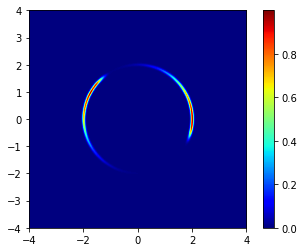

In [3]:
# To use the prior_chain to sample from, e.g. for plotting, we should first build it. This typically gets done inside the nested sampler, and if not should be done manually.
prior_chain.build()

u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * prior_chain.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(lambda x: prepare_func_args(log_likelihood)(**prior_chain(x)))(args).reshape((u_vec.size, u_vec.size))
plt.imshow(jnp.exp(lik), origin='lower', extent=(-4,4,-4,4),cmap='jet')
plt.colorbar()
plt.show()

In [4]:
ns = NestedSampler(log_likelihood, prior_chain)

results = jit(ns)(random.PRNGKey(42),adaptive_evidence_patience=2)


WARNING[2022-05-30 10:54:31,280]: Increasing max_samples (100000) by 200 to evenly divide samples_per_step
WARNING[2022-05-30 10:54:31,281]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.


In [5]:
# We can use the summary utility to display results
summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 293103
# samples: 1800
# likelihood evals / sample: 162.8
--------
logZ=-5.11 +- 0.15
H=5.7
ESS=387
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 0.48 +- 0.72 | -0.48 / 0.51 / 1.38 | -0.58 | 1.03
x[1]: 0.1 +- 1.8 | -1.9 / 0.9 / 2.0 | 1.9 | -1.7
--------


'--------\nTermination Conditions:\nSmall remaining evidence\n--------\n# likelihood evals: 293103\n# samples: 1800\n# likelihood evals / sample: 162.8\n--------\nlogZ=-5.11 +- 0.15\nH=5.7\nESS=387\n--------\nx[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nx[0]: 0.48 +- 0.72 | -0.48 / 0.51 / 1.38 | -0.58 | 1.03\nx[1]: 0.1 +- 1.8 | -1.9 / 0.9 / 2.0 | 1.9 | -1.7\n--------'

WARNING[2022-05-30 10:54:40,790]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING[2022-05-30 10:54:41,332]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


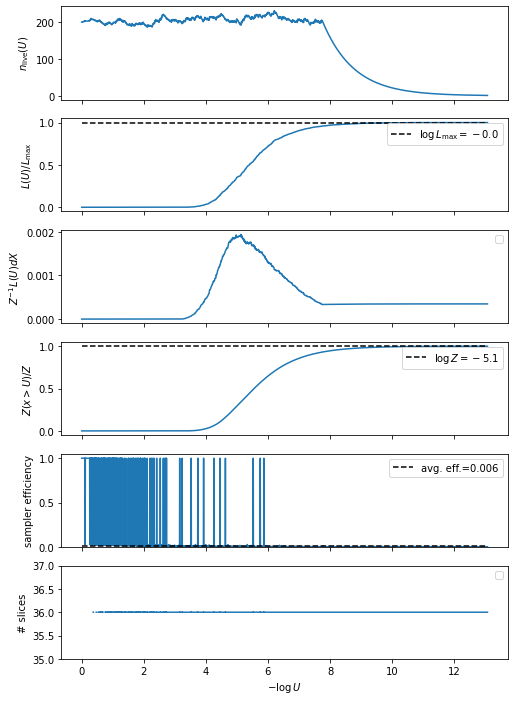

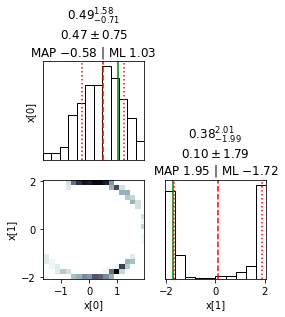

In [6]:
# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)